# Thinkful Capstone Project: Crater Detection

My capstone project is to develop a crater detection algorithm.<br>

## Why Crater Detection?

Craters are an import feature for planetary geologists; the density and size distribution of craters is often the best measure scientists have to estimate the age of a surface on a planet, moon, or other object.<br><br>
The problem is that there are a lot of craters; most craters larger than 1km in diameter have been hand documented and cataloged by dedicated astronomers. As the likelihood of impact increases with smaller impact objects, the number of craters of smaller sizes increases exponentially. Hand-counting craters smaller than 1km is simply not feasible. <br><br>
For this reason, the need for a crater detection algorithm has been discussed for decades; research in the field had been disappointing until a number of researchers (<a href='https://arxiv.org/pdf/1601.00978.pdf'>Cohen, et al.</a>, 2016;  <a href='http://events.ulg.ac.be/geoday/wp-content/uploads/sites/84/2017/08/GEO_RS-Glaude-Cornet.pdf'>Quentin & Glaude</a>, 2017) started applying convolutional neural networks to the problem in recent years. This approach has finally made automated crater detection a viable tool for scientific measurements.

## Applying Crater Detection Research

While there is much promising research here, there is a glaring lack of usable software; the work done in this field has all been experimental. It is typical that academic papers precede deployable products; however, unlike some computer vision applications, crater detection lacks the potential for an immediate high-revenue application. The users will be few, and research grants to planetary geology projects aren't always generous. It's therefore unsurprising that no major projects to make crater detection accessible have emerged.<br><br>
This is where I found the perfect data science product for my capstone project; applying this research to deliver a <I>product</I> that people can use.

## PyCDA: An Open-Source Crater Detection Project

PyCDA is my python package for sub-km crater detection. It's a fully licensed and registered package now available on its alpha version, pycda-0.1.1. You can even install it from PyPI with "pip install pycda" (currently only supports python 3.6). It can find craters in images "out of the box." For a brief overview of the pycda API, take a look at the <a href='https://github.com/AlliedToasters/PyCDA/blob/master/demo.ipynb'>usage demo</a> on the <a href='https://github.com/AlliedToasters/PyCDA/'>PyCDA repository</a>.

## Building PyCDA: From Data to Product

To build the alpha version of PyCDA, I used a dataset referenced and used often in crater detection papers, generated by Urbach & Stepinsky in the 2009 paper <I><a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>Automatic Detection of Sub-km Craters in High Resolution Planetary Images</a></I>. The tiles are 1700x1700 pixels at a resolution of 12.5 meters/pixel, over the Nanedi Valles; this is an interesting and well-chosen dataset because it includes a lot of non-crater features, particularly in the "central" region. This dataset comes with a list of 3658 annotated crater locations and sizes across the size tiles.

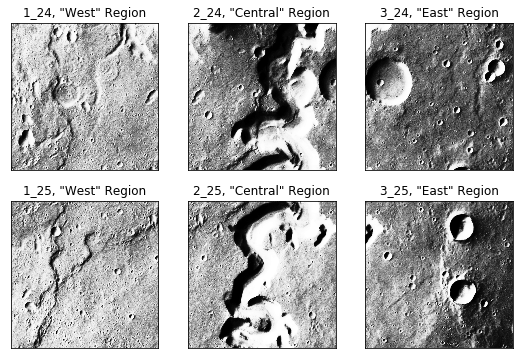

In [1]:
from capstone_code import tile_names, regions, tiles, plot_tiles
%matplotlib inline
plot_tiles(tiles, tile_names, regions)

# Pixels into Features: The Power of Convolutional Neural Networks
Convolutional neural networks (CNNs) have become very popular because of a particular property: they <I>learn features</I> on their own using an algorithm called backpropagation. This process, combined with convolution layers, creates <b>filters</b> that extract important patterns from the raw pixel data. Where researchers like Urbach and Stepinsky would apply hand-selected filters to find craters, convolutional nets are able to automatically generate them.<br><br>
The image below shows the output of the first convolutional layer of my network. Notice that the resulting images generally exhibit less noise, and circular edge features of the craters in the image tend to stand out.

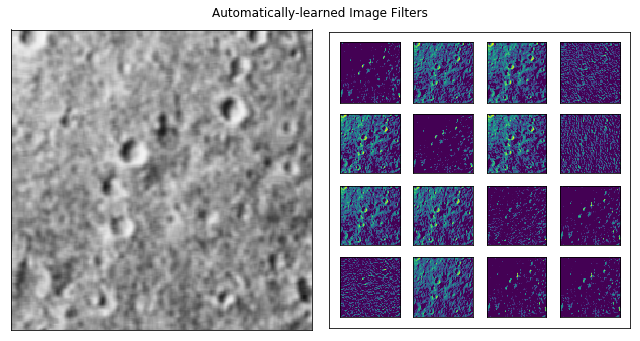

In [2]:
from capstone_code import plot_filters
plot_filters()

These outputs of the early layers of the convolutional net are filtered versions of the input image, and they become the features our model uses to make its prediction.

### The Max Pooling Problem

Convolutional nets are extremely powerful image classifiers, but their classification ability relies heavily on a process called <b>max pooling</b>. Max pooling reduces x and y dimensions of the image, passing valuable information about the identity of objects in the image to later layers. This is a problem for my model because the <I>location</I> and <I>size</I> of the craters are as important as their identification.<br><br>
The formal name of this computer vision problem is <b>image segmentation</b>, and it's the tricky counterpart of image classification problem that CNN's handle so well.

### The solution: U-Net Model

A paper by Ronneberger, et al. in 2015 called <I><a href='https://link.springer.com/chapter/10.1007%2F978-3-319-24574-4_28'>U-Net: Convolutional Networks for Biomedical Image Segmentation</a></I> introduced the U-Net architecture, which changed the way convolutional nets can be applied to image segmentation.<br><br>
The basic idea is to preserve the valuable location information from convolutional layers before max pooling by recalling these outputs and concatenating them with later <I>de</I>convolutional layers, which restore resolution to the data moving through the neural net. The following diagram was taken from the UNI Freiburg Department of Computer Science page.

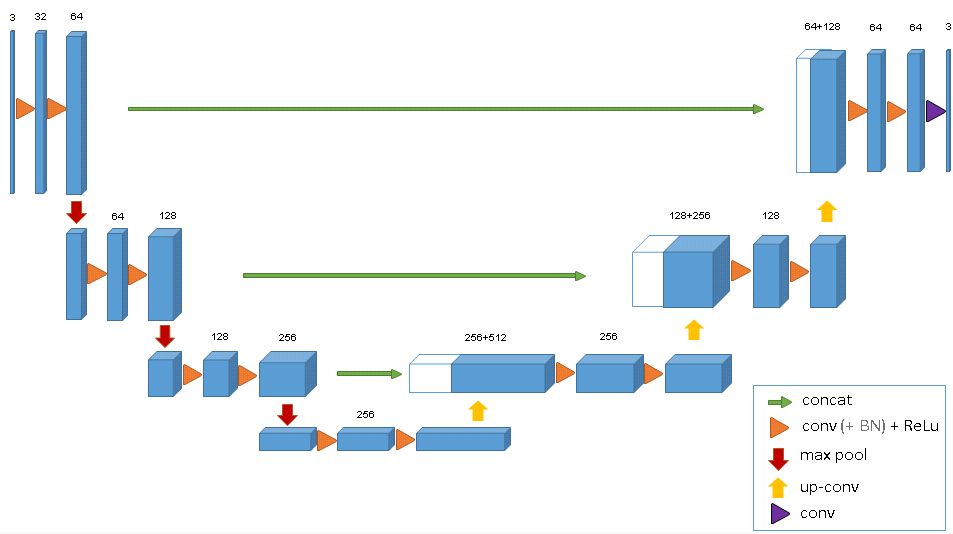

In [3]:
from capstone_code import unet_img
unet_img

This diagram illustrates the  way that previous spacial information is preserved by the U-Net structure; this strategy helps the network perform classification and return that information to the resolution of the input image.

## Supervised Learning with Our Data
The U-Net is a powerful tool, but it needs to be trained in a supervised setting. We need to "show" the network the right answer for it to learn. Because the model is making a per-pixel binary prediction, we need to convert our annotated crater data into pixels. The formal term for this type of image target is a "mask." For our sample image, the mask looks like this:

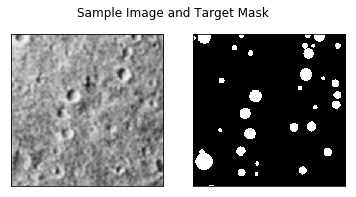

In [4]:
from capstone_code import plot_mask
plot_mask()

To train the model, I used binary cross entropy on the pixel-wise output of the U-net. This means that every pixel contributes to the total loss; formally, where $p_i$ is the <I>true value</I> of the ith pixel and $q_i$ is the <I>predicted</I> value of the ith pixel, the cross entropy loss of the model output $H$ is defined by:<br>

$$ H = -\sum_{i}p_i\ log\ q_i $$

To optimize, I used RMSprop, which is a variant of the Adam optimization algorithm. I implemented the model with Keras using the tensorflow backend.

## Training in the Cloud

For training, I took advantage of the <a href='https://colab.research.google.com'>Google Colaboratory notebook</a>, which offers free(!) GPU computation; the optimization process took about an hour per epoch on my CPU, and on Colaboratory it took <I>less than a minute</I> per epoch. I stopped training when my model achieved a log-loss score of .056, with an 98.5% pixel-wise accuracy score; this is the point where the model begins to overfit the training data to a negative effect on the validation score.

## Holdout Group and Model Output
During training, I reserved one image tile, labeled "2_25," which includes a portion of the Nanedi Valles; I chose this as the holdout group because it contains a lot of noisy features which could cause problems for my model. I want to understand the types of errors non-crater features will produce.<br><br>
The holdout tile and the output of the U-Net model look like this:

/home/alliedtoasters/miniconda3/envs/dev1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


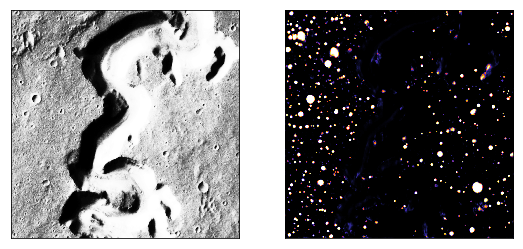

In [5]:
import pycda

cda = pycda.CDA()
prediction = cda.get_prediction(tiles['2_25'])
prediction.show_detection()

It's interesting to see how the model output compares to the actual targets:

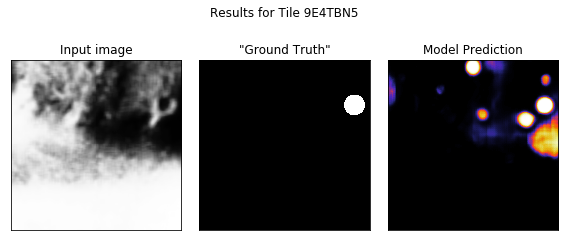

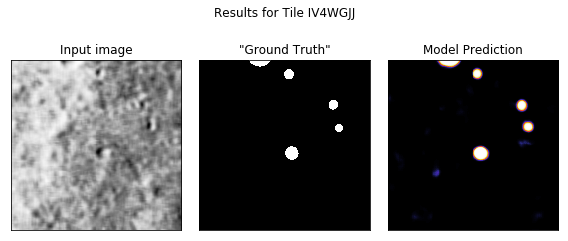

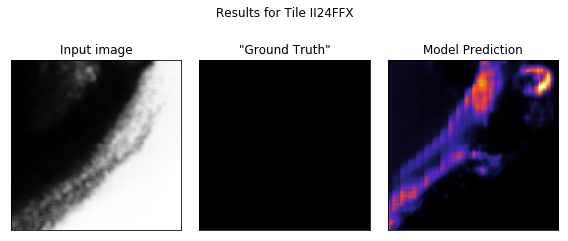

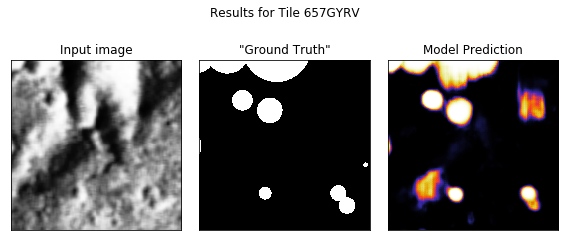

In [6]:
from capstone_code import inspect_detection

inspect_detection('9E4TBN5');
inspect_detection('IV4WGJJ');
inspect_detection('II24FFX');
inspect_detection('657GYRV');

Here we see the way the model returns good detections, with some false detection in the mix. Non-crater features tend to produce non-zero outputs, with some dim patterns visible in certain areas. This effect makes the classification phase later on important.

## Extracting Crater Proposals
The process of turning crater annotations (x, y, diameter) into circles was fairly simple; sci-kit image <a href='http://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.circle'>has a tool for that</a>. The opposite process, converting the output back into x, y, diameter format, is not so simple.<br><br>

Changing those detections back into crater annotations is a process I call "crater proposal extraction." My first iteration of the model handled this problem with a simple algorithm. The steps are:

 1. Binarize the model output. Set a threshold at .5; every pixel above .5 is assigned to 1, every below to 0.
 2. Isolate the "blobs." Every group of pixels with value 1 surrounded by 0's ("background") is an object.
 3. For each object, compute the mean pixel position; this is the crater location.
 4. Use the number of pixels as the area of the crater proposal; convert to diameter via basic circle geometry:
 
 $$A = \pi\ r^{2}$$
 $$d = 2\ \sqrt{ \pi\ A}$$<br>
This method worked well enough for most cases. For example, this section of the holdout tile:

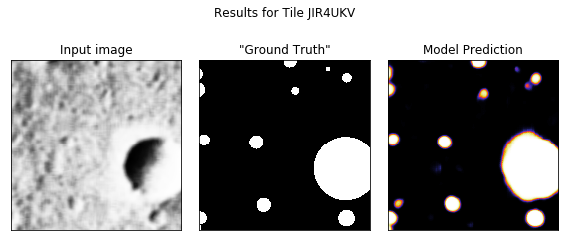

In [7]:
inspect_detection('JIR4UKV');

Here, the circle approximation method works pretty well; Each crater is nicely separated from its neighbors. In some cases, it doesn't work very well. Take a look at all the detections on the holdout tile; you'll notice the algorithm has grouped a clump of touching craters in the upper-lefthand corner together and called them a single crater. That's not awesome.

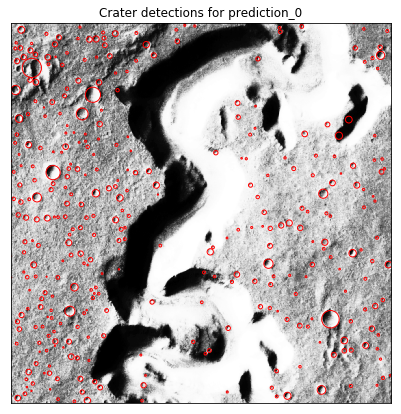

In [9]:
prediction.show(include_ticks=False);

## Clustering: An Unsupervised Approach
The basic problem of finding 

## Classification
The final piece of the CDA pipeline is classification; the algorithm produces enough false candidates to make this an important step.<br><br>
To classify craters, I use a simple, tiny convolutional neural net. PyCDA takes the crater proposal annotations and crops the input image in 12x12 pixel squares. It then feeds these tiny images to the classifier for a prediction.<br><br>
Unlike the U-Net model, here we are not concerned about the size or location of the crater. In fact, PyCDA crops the proposals such that the crater candidate takes up a fixed area within the center of the image. This allows us to worry less about translational invariance and focus on pure predictive performance.


## Error Analysis

A valuable feature of the PyCDA package is its error analysis submodule, error_stats. The core utility of this module is the crater - detection matching algorithm. This is a tricky processes that required some significant work to figure out.<br><br>
My first intuition was to use a nearest neighbors search; because all three of the defining characteristics of a crater annotation share the same dimensions, namely distance in pixels, the three-dimensional euclidian distance between craters and detections makes a great measurement of similarity.<br><br>
Then we need to decide a criterea to call a detection good or bad. If a crater's diameter or center location is off by a few pixels, it's ok; for the purpose of counting craters, this is acceptable. However, at some margin of error the detection must be considered bad.<br><br>
I tried a few distances for this critera, but it quickly became apparent that size matters; the same distance would not work for small craters and large craters. I would need to scale the error, which is the euclidian distance between the crater and its nearest detection, by the known crater diameter.<br><br>
Formally, the error $e$ between a known crater and its nearest detection is:

$$e = \sqrt{\Delta x^{2} + \Delta y^{2} + \Delta d^{2}}$$

where $\Delta x$ and $\Delta y$ are the distances between the known crater center and the nearest detection center in the $x$ and $y$ directions, and $\Delta d$ is the difference in diameter between the known crater and the detection. The threshold to consider a known crater detected, where $d$ is the known diameter of the crater, is:

$$ \frac{e}{d} < .4 $$

To visualize this, look at the following diagrams. With this criteria, the red circles would be rejected as crater candidates, and the green circles are perfect detections. Any detections closer than the red circles is considered a correct detection by the matching criteria.

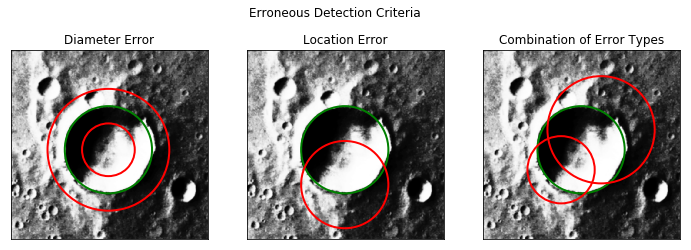

In [2]:
from capstone_code import detection_error_example

detection_error_example()

In [7]:
from pycda.error_stats import ErrorAnalyzer
from pycda.sample_data import get_sample_csv

prediction.known_craters = get_sample_csv()
an = ErrorAnalyzer()
an.analyze(prediction)

242 craters were properly detected.
Matching complete!


Detection Percentage: %59.2

Precision: 0.69

Recall: 0.59

F1-Score: 0.64

False Discovery Rate: 0.31

False Negative Rate: 0.41

Branching Factor:  0.44

Quality Percentage: %46.9 



You'll get a printout of some error statistics. You can see we've detected close to 60% of the craters in our image, with a pretty even distribution of error types; our model seems slightly more prone to missing craters than presenting false detections, but both types of errors are present.

### Visualizing Errors

The ErrorAnalyzer object has some visualization tools; to see a map of detections, known craters, and matches, call .show():

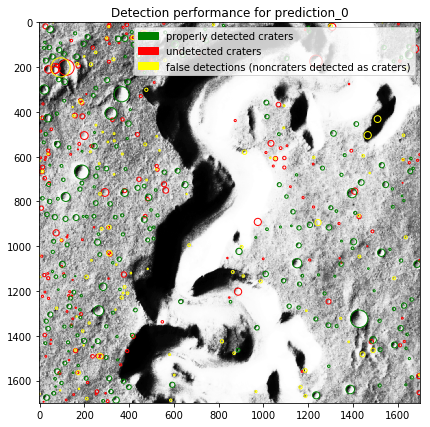

In [8]:
an.show()

To compare estimated to known crater counts by size, use .plot_densities():

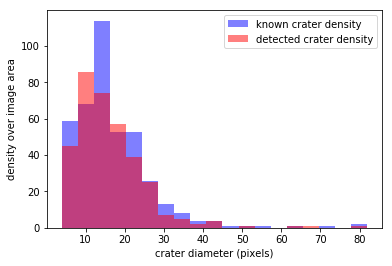

known crater count in image:  409
detected crater count in image:  349


In [9]:
an.plot_densities()

## Algorithm Function and Improving Performance

PyCDA produces detections using a three-step pipeline:

   1. Detection: The detector model makes a pixel-wise prediction.
   2. Extraction: A geometric model converts groups of pixels into crater proposals.
   3. Classification: A binary classifier inspects each proposal and decides if it is a crater or a false detection.<br>
   
Improving any one of these three steps can improve model performance.

### 1. Detection

The output of the detection model in our example looks like this:

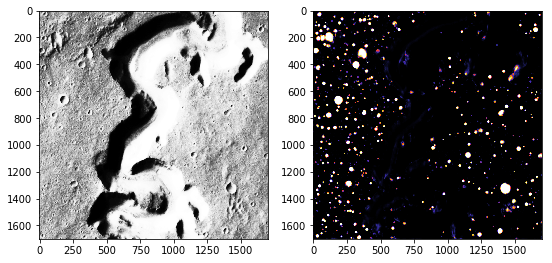

In [10]:
prediction.show_detection()

We can see the splotches where craters have been picked up by the model.<br>
PyCDA uses a "U-net" convolutional neural network to produce these detections; this type of model was selected because it gives highly location-specific predictions. It is implimented through keras and tensorflow under the hood.

### 2. Extraction
We've got a pretty map of potential craters. Extraction is the process of converting these splotches into simple, three-point detections: lat, long, and diameter.

By default, PyCDA models these splotches as circles; after binarizing the detection image, the extractor identifies independent groups of nonzero pixels. It then computes the centroid of these pixel groups and uses the number of pixels as the area of the circle to compute its diameter.

It's a simple approach and it works well... sometimes. Its biggest problem comes from "touching" craters, such as the tight group located in the upper-lefthand corner of our sample image. That's why you'll notice our detection map puts one big crater right in the center of that group.

An alternative approach is to use an image processing technique to identify unique "blobs" in a group of touching "blobs" called <a href='http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html'>watershed segmentation</a>. PyCDA comes with the option to use this technique as an alternative to the circle model.

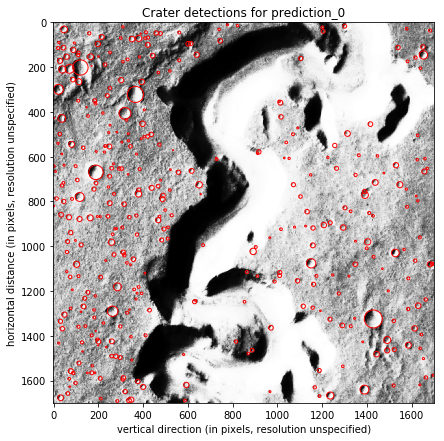

In [11]:
new_cda = CDA(extractor='watershed')
new_prediction = new_cda.get_prediction(image)
new_prediction.show()

It looks like that took care of the issue! The downside to this segmentation technique is that it tends to produce a higher number of small detections and lower-quality diameter measurements. Let's see how the detection performance compares:

In [12]:
new_prediction.known_craters = prediction.known_craters
an.analyze(new_prediction)

260 craters were properly detected.
Matching complete!


Detection Percentage: %63.6

Precision: 0.69

Recall: 0.64

F1-Score: 0.66

False Discovery Rate: 0.31

False Negative Rate: 0.36

Branching Factor:  0.44

Quality Percentage: %49.6 



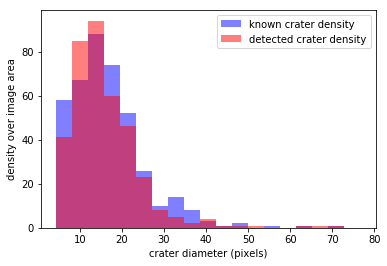

known crater count in image:  409
detected crater count in image:  375


In [13]:
an.plot_densities()

It looks like that bought us a bump in overall performance!

### 3. Classification

The final step in the pipeline is a binary classifier; PyCDA takes the proposals from the extractor, crops tiny images of the proposals from the input image, and feeds them to the classifier for prediction.
The default classifier is a small convolutional neural net that takes a 12x12 pixel cropped image of the crater as an input; it does a decent job of weeding out the bad detections.<br><br>
The first version of PyCDA does not come with any additional classifiers, but a user can easily use the CustomClassifier class to try a new one. PyCDA will automatically detect input dimensions, which makes plugging a custom model into the pipeline very easy; the user only needs to specify the filepath to the saved keras model and 'crater_pixels,' the number of pixels the crater candidate should occupy in the center of the cropped images.

In [ ]:
from pycda.classifiers import CustomClassifier

#This is a new classifier that I trained using more parameters,
#regularization, and other fancy neural net stuff.
my_classifier = CustomClassifier(model_path='../Documents/crater_models/sample_classifier.h5', crater_pixels=6)
new_cda.classifier = my_classifier
third_pred = new_cda.get_prediction(image)

In [ ]:
third_pred.known_craters = new_prediction.known_craters
an.analyze(third_pred)

Oops! Looks like I'd better stick with the default classifier...

# PyCDA: Fast, Flexible Crater Detection
Most users will have a very specific task in mind when using PyCDA; that's why it's designed to apply custom models and varied image formats for maximum flexibility. Use the CustomDetector and CustomClassifier classes to quickly deploy your models and get detecting!